In [58]:
from pathlib import Path
import numpy as np
import cv2 as cv
import supervision as sv
import matplotlib.pyplot as plt

In [47]:
PATH_MAT = Path("./material/")
PATH_WP = PATH_MAT / "white_patch"
PATH_RES = Path("./res")

for p in (PATH_MAT, PATH_WP, PATH_RES):
    assert p.exists() and p.is_dir(), f"Error when looking for path {p}"

# Parte 1: White Patch

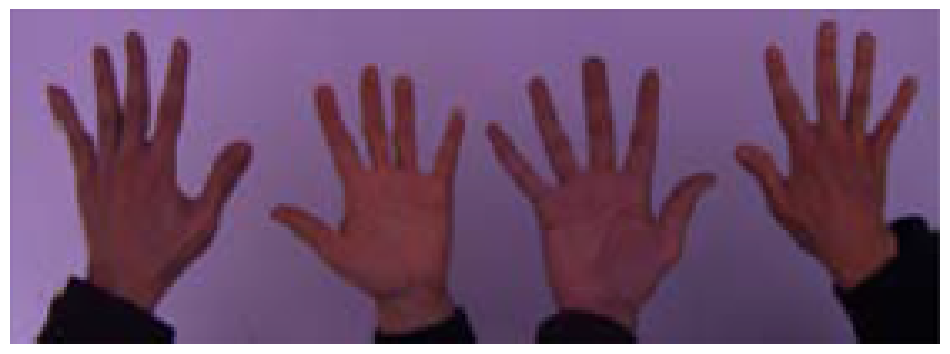

In [39]:
# mostramos un ejemplo
fname = 'test_blue.png'
img = cv.imread(PATH_WP / fname)
sv.plot_image(img)

In [37]:
# implementación
def white_patch(img: np.ndarray, q: float = 0.95) -> np.ndarray:
    """Apply white patch to image using a quantile instead of max value for each channel.

    Args:
        img (np.ndarray): RGB image as a numpy array with shape (m,n,3) and dtype uint8.
        q (float): Quantile lying in the (0,1) range. Defaults to 0.95.

    Returns:
        np.ndarray: Modified image.
    """
    # get quantiles channel-wise
    qs = np.quantile(img, q, axis=(0,1), keepdims=True)

    # transform image
    res = img * (255 / qs)

    # clip to prevent overflow
    res = res.clip(0,255)
    
    # restore dtype and return
    return res.astype(img.dtype)


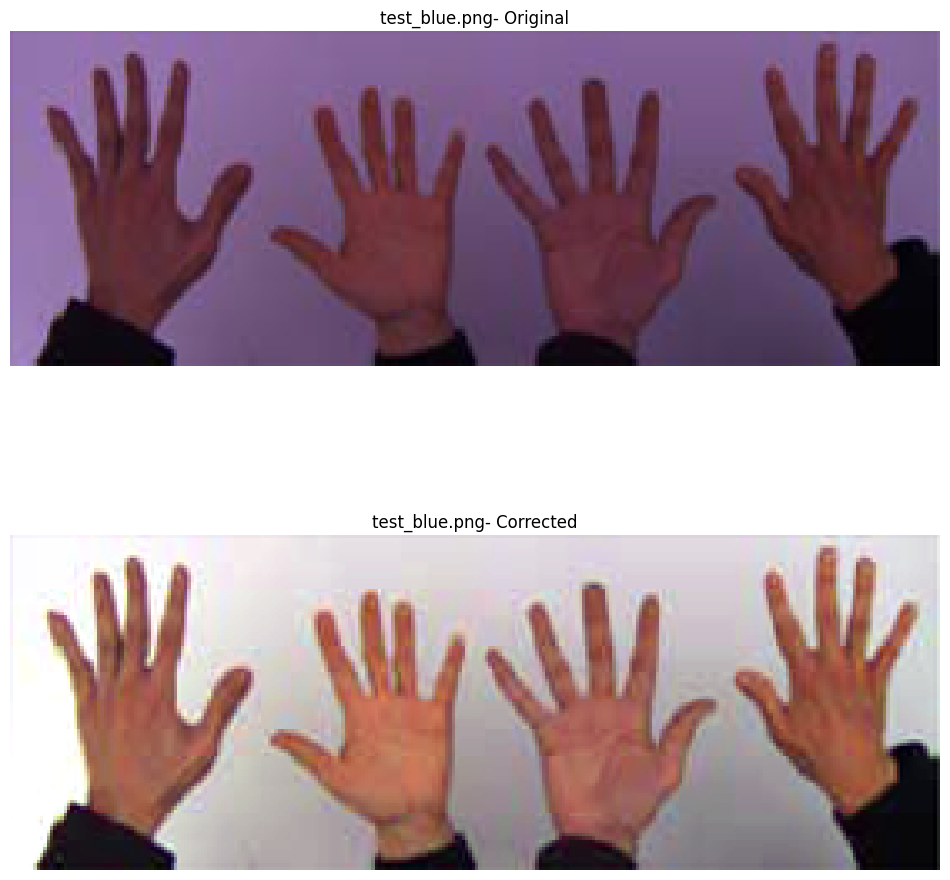

In [42]:
# mostramos el ejemplo corregido
corrected_img = white_patch(img, 0.95)

sv.plot_images_grid(
    [img, corrected_img],
    grid_size=(2,1),
    titles = [fname + f"- {kind}" for kind in ('Original', 'Corrected')]
)

En este caso el resultado es muy bueno.

In [ ]:
# generamos resultados para todos para tres valores diferentes de q
# 0.9 y 0.95 son los que nos importan
# 1 es el máximo para mostrar cómo se comporta en algunas instancias

Q_GRID = (0.9, 0.95, 1)
for q in Q_GRID:
    # if folder does not exist yet, create it
    res_path_q = PATH_RES / f"q_{q}"
    if not res_path_q.exists():
        res_path_q.mkdir()

    # process for each path
    for p in PATH_WP.iterdir():
        fname = p.name

        img = cv.imread(p)

        corrected_img = white_patch(img, q)

        cv.imwrite(res_path_q / fname, corrected_img)

A continuación mostramos dos ejemplos, aunque las observaciones son consistentes con el resto de las imágenes corregidas, que se pueden apreciar en `/res` en la correspondiente subcarpeta a cada cuantil.

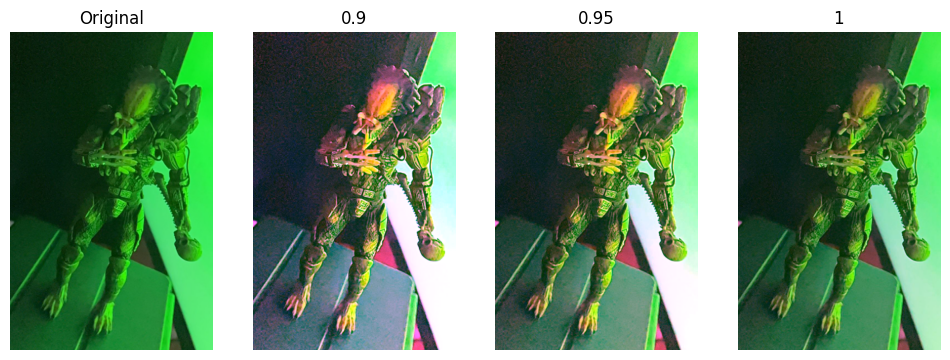

In [55]:
# mostramos uno de los predator
fname = 'wp_green.png'

img = cv.imread(PATH_WP / fname)

corrections = {
    q:cv.imread(PATH_RES / f"q_{q}" / fname)
    for q in Q_GRID
}

sv.plot_images_grid(
    [img] + list(corrections.values()),
    grid_size=(1,len(corrections)+1),
    titles=['Original']+list(str(q) for q in corrections.keys())
)

Si bien el resultado no es perfecto, es bastante decente. Algunas zonas, como la cabeza del predator, se ponen un poco rojas para `q=0.9`.

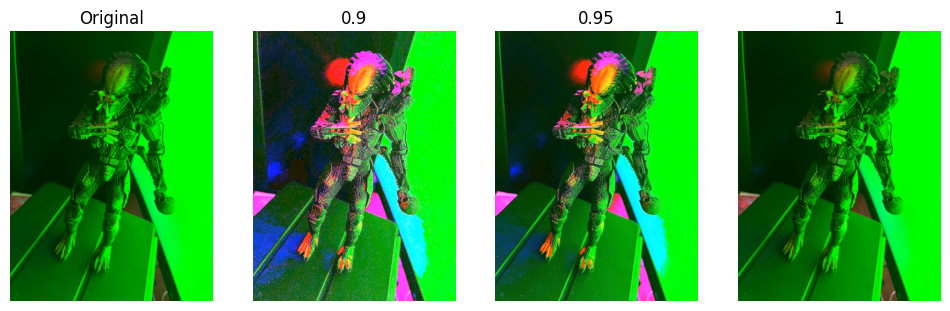

In [56]:
# la versión 2
fname = 'wp_green2.jpg'

img = cv.imread(PATH_WP / fname)

corrections = {
    q:cv.imread(PATH_RES / f"q_{q}" / fname)
    for q in Q_GRID
}

sv.plot_images_grid(
    [img] + list(corrections.values()),
    grid_size=(1,len(corrections)+1),
    titles=['Original']+list(str(q) for q in corrections.keys())
)

Vemos que en estos casos el algoritmo no funciona bien. Aparecen manchas de color que había antes en las imágenes pero que ahora resultan exageradas, especialmente para valores más bajos de `q`. Por otra parte, utilizar `q=1` no ayuda en nada.

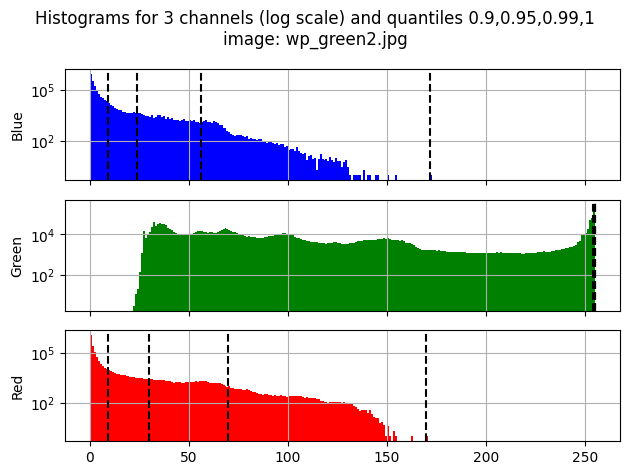

In [88]:
# observamos histograma por canal de original
fig, axes =  plt.subplots(nrows=3, sharex=True)

plot_qs = [0.9, 0.95, 0.99, 1]

for idx,(ax, color) in enumerate(zip(axes, ('Blue','Green','Red'))):
    data = img[:,:,idx].flatten()
    ax.hist(data, bins=range(256), log=True, color=color)
    ax.grid(True)
    #ax.set_title(color)
    lims = ax.get_ylim()
    ax.vlines(np.quantile(data, plot_qs),*lims, 
              color='black', linestyle='dashed')
    ax.set_ylabel(color)
    ax.set_ylim(*lims)

fig.suptitle(
    "".join(['Histograms for 3 channels (log scale) ',
             f"and quantiles {",".join(str(x) for x in plot_qs)}",
             "\n"
             f"image: {fname}",
]))
plt.tight_layout()

Como se puede apreciar, tanto para el azul como para el rojo las distribuciones hacen que los cuantiles altos queden lejos del máximo y por tanto regiones concentradas se saturen. En estos casos se especula que métodos locales (en vez de globales) podrían mejorar la performance, aunque quedan fuera del alcance del trabajo.

# Parte 2: Histogramas

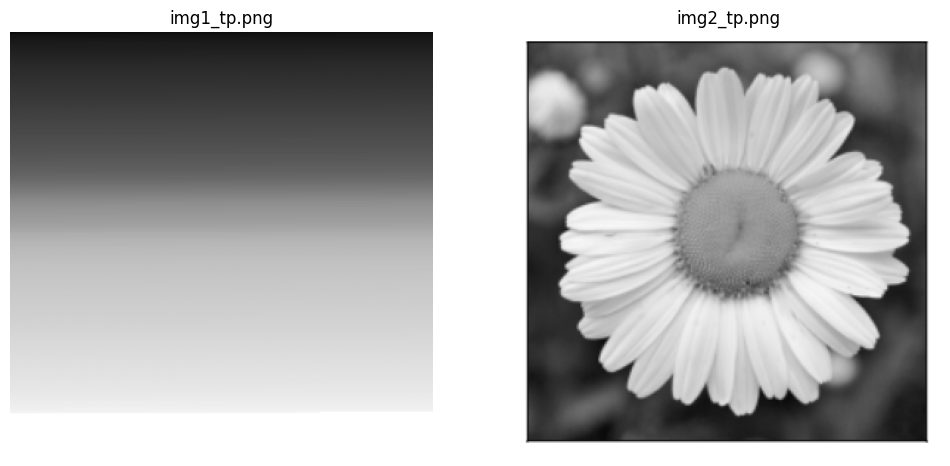

In [93]:
# levantamos ambas imagenes
names = [f"img{i}_tp.png" for i in (1,2)]
imgs = [
    cv.imread(PATH_MAT / fname, cv.IMREAD_GRAYSCALE)
    for fname in names
]

sv.plot_images_grid(
    imgs,
    grid_size=(1,2),
    titles=names
)

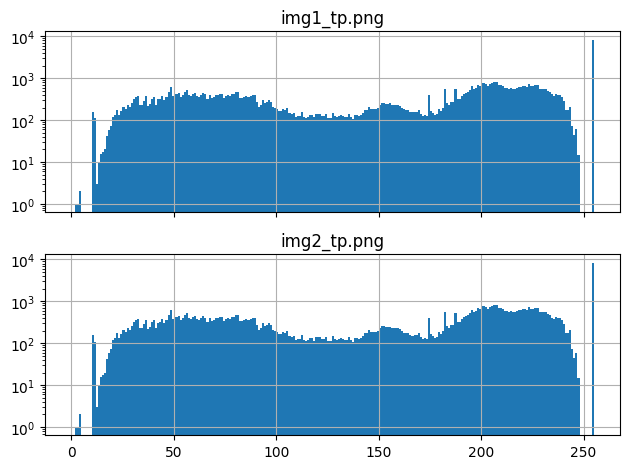

In [95]:
# mostramos sus histogramas

# como base usamos 256 bins, i.e. todos los valores posibles

fig, axes =  plt.subplots(nrows=2, sharex=True)

for ax, fname, img in zip(axes, names, imgs):
    ax.hist(img.flatten(), bins=range(256), log=True)
    ax.grid(True)
    ax.set_title(fname)


plt.tight_layout()

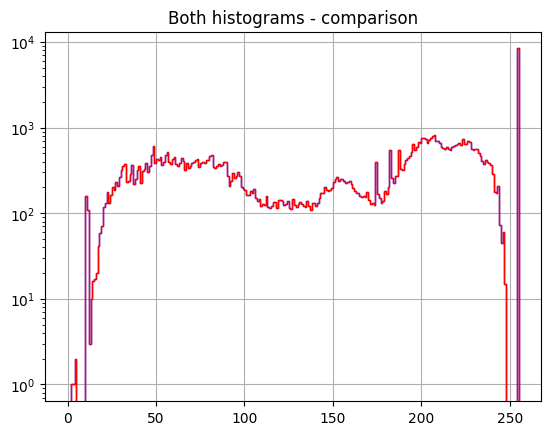

In [129]:
# para mayor impacto, los ploteamos sobre el mismo plano
fig, ax = plt.subplots()

for img, color in zip(imgs, ('blue','red')):
    ax.hist(img.flatten(), bins=range(256), log=True, color=color,
            histtype='step')
ax.grid(True)
ax.set_title("Both histograms - comparison")
plt.show()

Como se puede apreciar, tienen una distribución de valores idéntica. En este caso no resultaría de utilidad usar el histograma para un modelo predictivo que intente distinguir una imagen de la otra. 

Como observación extra, la imagen de la izquierda es artificial mientras que la de la derecha no. Es razonable considerar que la primera es un ejemplo de ataque _adversarial_ y que dependiendo de las condiciones en las que se despliegue el modelo tal construcción podría no ser posible.

## Extra

Se agrega un suavizado Gaussiano a cada imagen previo a toma del histograma.

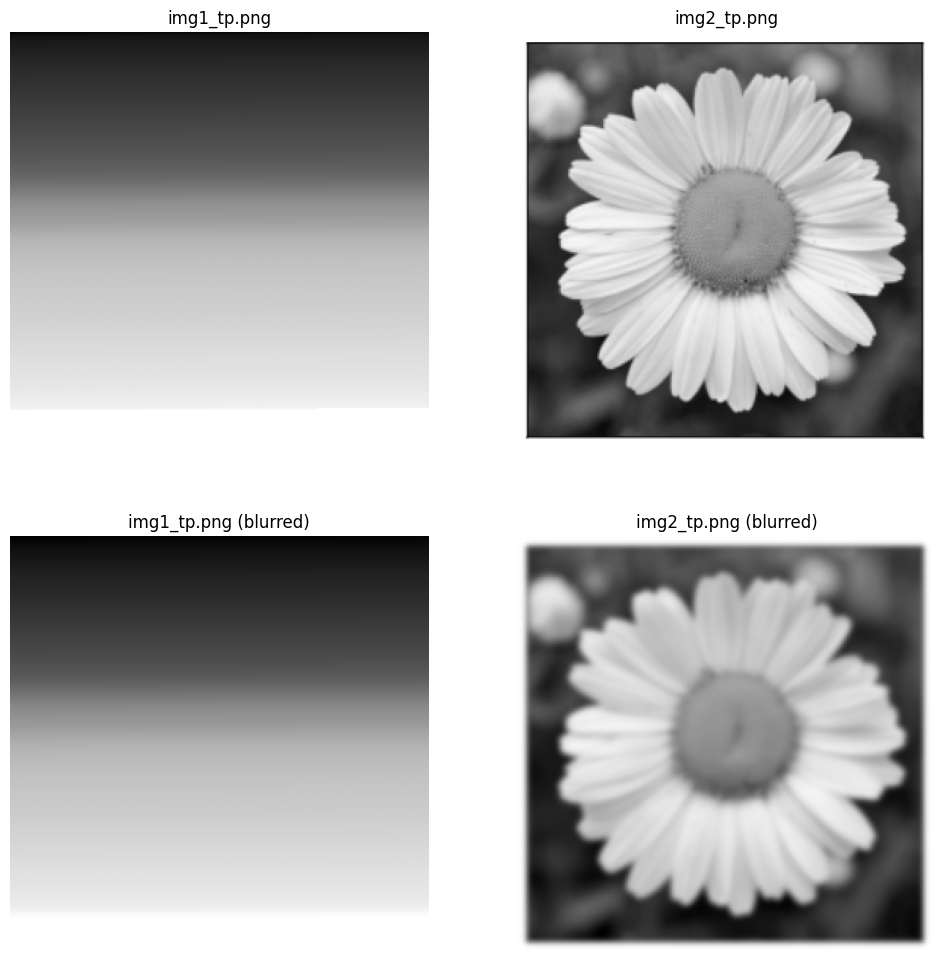

In [131]:
blurred_imgs = [
    cv.GaussianBlur(img, ksize=(15, 15), sigmaX=2,  sigmaY=2)
    for img in imgs
]

sv.plot_images_grid(
    imgs+blurred_imgs,
    grid_size=(2,2),
    titles=names+[f'{name} (blurred)' for name in names]
)

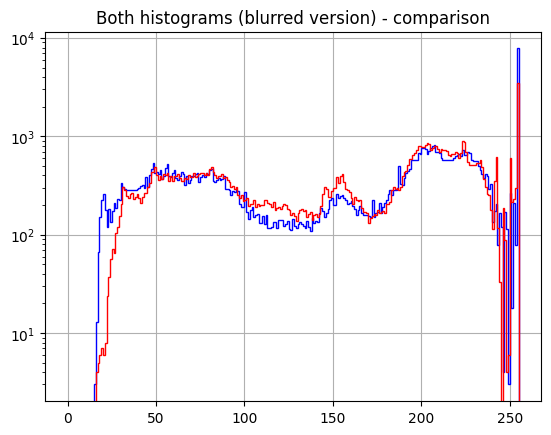

In [132]:
# directamente graficamos uno contra otro
fig, ax = plt.subplots()

for img, color in zip(blurred_imgs, ('blue','red')):
    ax.hist(img.flatten(), bins=range(256), log=True, color=color,
            histtype='step')
ax.grid(True)
ax.set_title("Both histograms (blurred version) - comparison")
plt.show()

Al utilizar un método local como es el suavizado Gaussiano, en una imagen "natural" que tiene variación de color local (vs. un gradiente 1d como la imagen artificial) el histograma se diferencia un poco. Sin embargo, esto también podría ser "atacable" e incluso post-aplicación del suavizado los histogramas siguen siendo muy parecidos.

## 